In [57]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mdates

# Load your data
df = pd.read_csv("15MIN-Updated.csv", parse_dates=["DateTime"])
df.set_index("DateTime", inplace=True)

In [58]:
import mplfinance as mpf
import pandas as pd
import numpy as np

class CandlePlotter:
    def __init__(self, data: pd.DataFrame, chart_info: dict):
        """
        data: DataFrame with OHLC and CrossSignal columns (and ideally RSI column)
        chart_info: dict with config like {"title": "My Chart"}
        """
        self.data = data.copy()
        self.data.index = pd.to_datetime(self.data.index)  # Ensure datetime index
        self.chart_info = chart_info

    # -----------------------------
    # RSI subplot builder
    # -----------------------------
    def _build_rsi_plot(self):
        """Return addplots for RSI (main line + levels)."""
        if "RSI" not in self.data.columns:
            return []
        return [
            mpf.make_addplot(self.data["RSI"], panel=1, color="blue", ylabel="RSI"),
            mpf.make_addplot(np.full(len(self.data), 70), panel=1, color="red", linestyle="--"),
            mpf.make_addplot(np.full(len(self.data), 30), panel=1, color="purple", linestyle="--")
        ]

    # Cross signal markers (buy/sell)
    # -----------------------------
    def _build_cross_signal_plots(self):
        """Return addplots for buy/sell markers using CrossSignal column."""
        if "CrossSignal" not in self.data.columns:
            return []

        plots = []

        # Full-length arrays with NaN where no signal
        buy_series = np.where(self.data["CrossSignal"] == 1, self.data["Low"] * 0.995, np.nan)
        sell_series = np.where(self.data["CrossSignal"] == -1, self.data["High"] * 1.005, np.nan)

        # Buy markers (green arrows below candles)
        plots.append(
            mpf.make_addplot(
                buy_series,
                type="scatter",
                marker="^",
                color="green",
                markersize=100,
                panel=0
            )
        )

        # Sell markers (red arrows above candles)
        plots.append(
            mpf.make_addplot(
                sell_series,
                type="scatter",
                marker="v",
                color="red",
                markersize=100,
                panel=0
            )
        )

        return plots


    # -----------------------------
    # Main plot method
    # -----------------------------
    def plot(self, show_rsi: bool = True):
        """Plot candlestick chart with optional RSI and cross signals."""

        addplots = []

        if show_rsi:
            addplots.extend(self._build_rsi_plot())

        addplots.extend(self._build_cross_signal_plots())  # ✅ add buy/sell markers

        fig, axes = mpf.plot(
            self.data,
            type='candle',
            style='classic',
            volume=False,
            figratio=(14, 7),
            figscale=1.2,
            returnfig=True,
            addplot=addplots
        )

        # Title on top of main chart
        axes[0].set_title(self.chart_info.get("title", "Candlestick Chart"))

        return fig


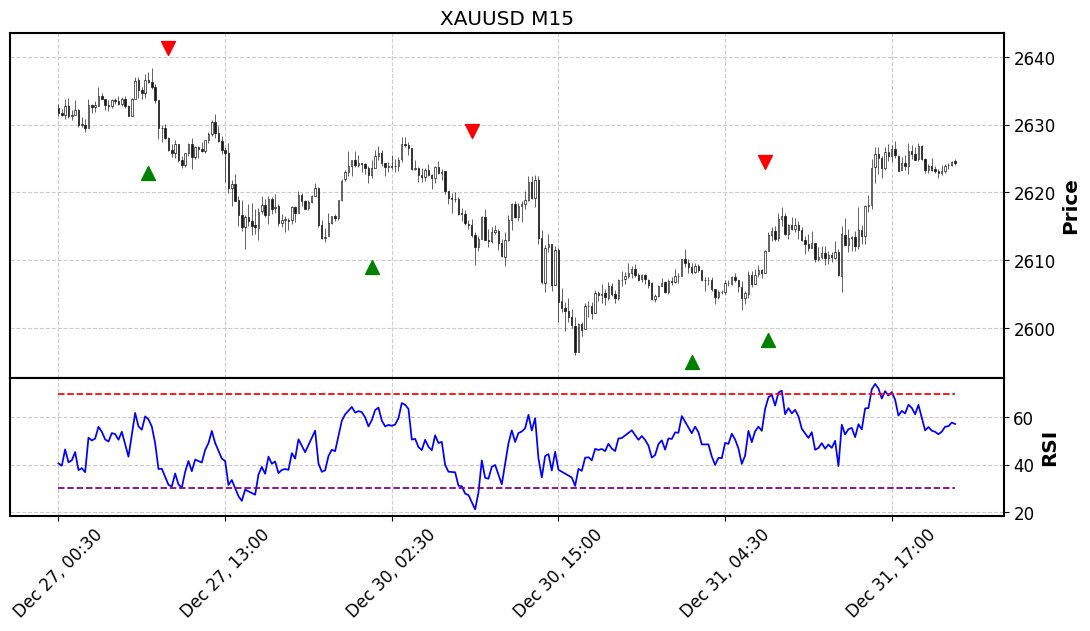

In [59]:
cp = CandlePlotter(df, {"title": "XAUUSD M15"})
fig = cp.plot()
